## Imports and Setup

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [125]:
sns.set_theme()

## Data Loading

In [126]:
raw_data = pd.read_csv("data.csv").drop(columns=["id"])

In [127]:
for column in raw_data.columns:
    print(column)

author
geometry
pressure [MPa]
mass_flux [kg/m2-s]
x_e_out [-]
D_e [mm]
D_h [mm]
length [mm]
chf_exp [MW/m2]


For ease of use, we'll remove the units from the column names

In [128]:
raw_data.columns = ["author", "geometry", "pressure", "mass_flux", "x_e_out", "D_e", "D_h", "length", "chf_exp"]
raw_data

,author,geometry,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8
...,...,...,...,...,...,...,...,...,...
31639,Thompson,NaN,NaN,1736.0,0.0886,NaN,7.8,591.0,2.3
31640,NaN,NaN,13.79,NaN,NaN,4.7,4.7,NaN,3.9
31641,Thompson,NaN,18.27,658.0,-0.1224,3.0,3.0,150.0,2.3
31642,Thompson,tube,6.89,3825.0,NaN,23.6,23.6,1972.0,3.7


To, start, we'll separate the data between rows that contain x_e_out and the ones that don't.

In [129]:
y_full = raw_data["x_e_out"]
X_full = raw_data.drop(columns=["x_e_out"])

y_train = y_full[ y_full.isna() == False ]
X_train = X_full[ y_full.isna() == False ]
X_test = X_full[ y_full.isna() ]

## Data Analysis

In [130]:
X_train.describe()

,pressure,mass_flux,D_e,D_h,length,chf_exp
count,18243.000000,18002.000000,17588.000000,18102.000000,18072.000000,21229.000000
mean,10.635066,3070.487779,8.589305,14.215446,830.564962,3.809129
std,4.332943,1784.873142,5.132207,19.913594,671.142170,1.988009
min,0.100000,0.000000,1.000000,1.000000,10.000000,0.800000
25%,6.890000,1505.000000,4.700000,5.600000,318.000000,2.400000
50%,11.030000,2730.000000,7.800000,10.000000,610.000000,3.400000
75%,13.790000,4069.000000,10.800000,11.500000,914.000000,4.700000
max,20.680000,7975.000000,37.500000,120.000000,3048.000000,19.300000


In [131]:
(X_test.describe() - X_train.describe()) / X_train.describe()

,pressure,mass_flux,D_e,D_h,length,chf_exp
count,-0.509456,-0.508332,-0.512850,-0.505414,-0.512340,-0.509398
mean,0.001623,-0.002447,0.014199,-0.008740,0.008897,-0.009686
std,0.000569,-0.013338,0.031359,-0.011399,0.005266,-0.006222
min,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.009302,0.063830,0.000000,0.000000,0.000000
50%,0.003626,0.003663,0.089744,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.021277
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [132]:
df_show = pd.DataFrame([X_train["author"].value_counts(), X_test["author"].value_counts()]).T
df_show.columns = ["Train", "Test"]
df_show

,Train,Test
Thompson,11621,5775
Janssen,1846,870
Weatherhead,1377,663
Beus,1087,517
Peskov,729,355
Williams,567,324
Richenderfer,371,174
Mortimore,130,67
Kossolapov,70,31
Inasaka,28,18


In [133]:
df_show = pd.DataFrame([X_train["geometry"].value_counts(), X_test["geometry"].value_counts()]).T
df_show.columns = ["Train", "Test"]
df_show

,Train,Test
tube,14121,7024
annulus,2971,1410
plate,424,194


Every author and geometry that appears in the test values also appears in the training values, and in similar proportions

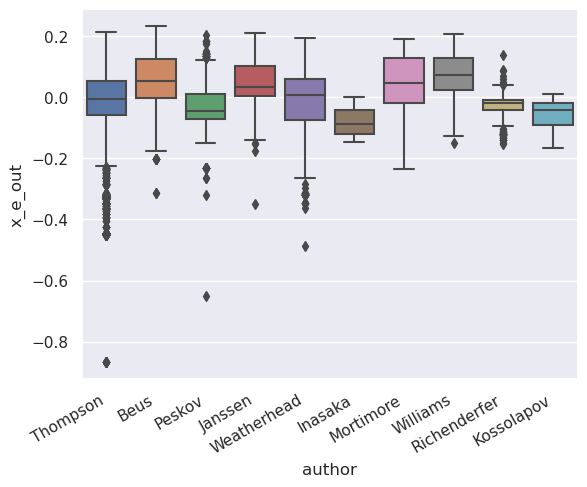

In [134]:
sns.boxplot(x=X_train["author"], y=y_train)
plt.xticks(rotation=30, horizontalalignment="right");

In [135]:
authors_list = list(X_train["author"].dropna().unique())

df_show = pd.DataFrame()
for author1 in authors_list:
    for author2 in authors_list:
        aux1 = y_train[X_train["author"] == author1]
        aux2 = y_train[X_train["author"] == author2]
        stat, pvalue = ttest_ind(aux1, aux2, equal_var=False)
        df_show.loc[author1, author2] = pvalue

df_show

,Thompson,Beus,Peskov,Janssen,Weatherhead,Inasaka,Mortimore,Williams,Richenderfer,Kossolapov
Thompson,1.000000e+00,8.949711e-125,9.314892e-11,7.152431e-191,8.976527e-01,1.446470e-08,1.587336e-10,2.209369e-139,1.891208e-15,2.835583e-10
Beus,8.949711e-125,1.000000e+00,3.414373e-103,6.626472e-04,1.167261e-69,3.044529e-16,1.308071e-01,1.212507e-05,2.362221e-133,1.133258e-34
Peskov,9.314892e-11,3.414373e-103,1.000000e+00,7.451508e-101,1.740544e-06,7.845439e-06,8.084805e-16,3.841412e-128,4.668231e-01,2.592335e-03
Janssen,7.152431e-191,6.626472e-04,7.451508e-101,1.000000e+00,2.642000e-66,7.002591e-15,7.368130e-01,5.044322e-17,2.308869e-141,4.145999e-30
Weatherhead,8.976527e-01,1.167261e-69,1.740544e-06,2.642000e-66,1.000000e+00,1.193956e-08,5.010518e-10,9.924373e-96,8.834356e-07,3.137612e-09
Inasaka,1.446470e-08,3.044529e-16,7.845439e-06,7.002591e-15,1.193956e-08,1.000000e+00,5.136253e-17,1.375311e-17,3.039333e-06,5.493467e-03
Mortimore,1.587336e-10,1.308071e-01,8.084805e-16,7.368130e-01,5.010518e-10,5.136253e-17,1.000000e+00,1.054542e-03,1.811494e-15,5.562950e-19
Williams,2.209369e-139,1.212507e-05,3.841412e-128,5.044322e-17,9.924373e-96,1.375311e-17,1.054542e-03,1.000000e+00,1.429819e-153,1.832441e-39
Richenderfer,1.891208e-15,2.362221e-133,4.668231e-01,2.308869e-141,8.834356e-07,3.039333e-06,1.811494e-15,1.429819e-153,1.000000e+00,2.914272e-04
Kossolapov,2.835583e-10,1.133258e-34,2.592335e-03,4.145999e-30,3.137612e-09,5.493467e-03,5.562950e-19,1.832441e-39,2.914272e-04,1.000000e+00


P-values for almost all pairings seem very low, indicating they are distinct values. That suggests the author field might be a good feature for imputting the target value.

``` python
# The image has been pre-rendered to save time
aux = pd.concat([X_train, y_train], axis=1)  
sns.pairplot(aux, hue="author")`
```

![](pairplot.png)

The features "D_e" and "D_h" seem to be quite closely correlated, so we'll take a closer look.

<Axes: xlabel='D_e', ylabel='D_h'>

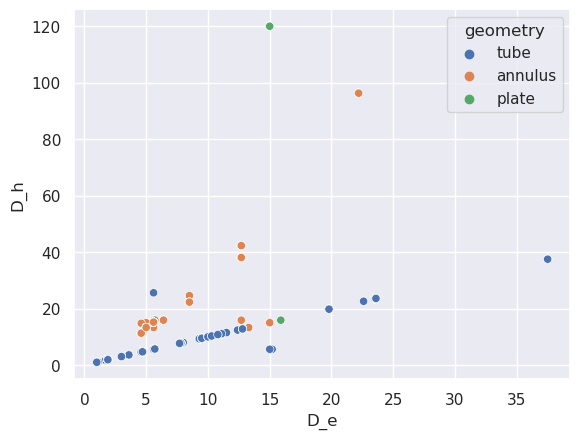

In [136]:
sns.scatterplot(data=X_train, x="D_e", y="D_h", hue="geometry")

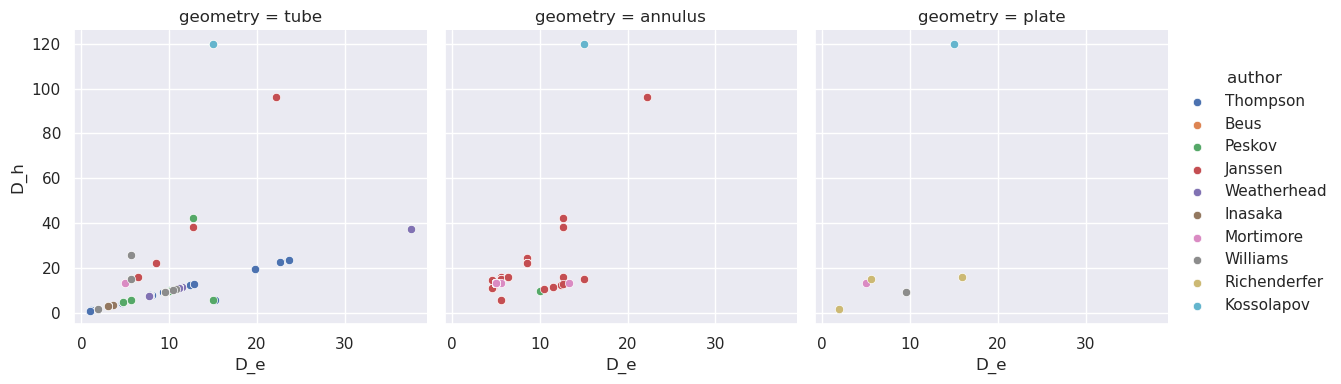

In [137]:
g = sns.FacetGrid(X_train, col="geometry", hue="author", height=4)
g.map_dataframe(sns.scatterplot, x="D_e", y="D_h")
g.add_legend()

In [138]:
X_train.isna().sum()

author       3403
geometry     3713
pressure     2986
mass_flux    3227
D_e          3641
D_h          3127
length       3157
chf_exp         0
dtype: int64

Since there are more values missing in D_e than D_h, we'll use the latter. When the geometry is "tube", we'll assume D_e = D_h. For the "annulus", we'll use a linear regression. For "plate", we'll use the median, to ignore the outliers.

## Pipeline and Model Construction

In [139]:
numerical_columns = ["pressure", "mass_flux", "D_e", "D_h", "length", "chf_exp"]
categorical_columns = ["author", "geometry"]

In [140]:
class Preprocessor:
    def __init__(self):
        self.cat_imputer = SimpleImputer(strategy="most_frequent")
        self.num_imputer = SimpleImputer(strategy="median")
        
    def fit(self, X_, y=None):
        self.cat_imputer.fit(X_[["author", "geometry"]])
        self.num_imputer.fit(X_[numerical_columns])
        return self
        
    def transform(self, X_, y=None):
        X = X_.copy()
        X[["author", "geometry"]] = self.cat_imputer.transform(X[["author", "geometry"]])
        X.loc[((X["geometry"] == "tube") & (X["D_h"].isna())),"D_h"] = X["D_e"]
        X[numerical_columns] = self.num_imputer.transform(X[numerical_columns])
        X = X.drop(columns=["D_e"])
        return X

In [165]:
# The function was inspired by the one in https://www.kaggle.com/code/iqbalsyahakbar/ps3e15-eda-imputing-ensemble-for-beginners/
def cross_validation_score(splits, model, model_name):
    X = X_train.copy()
    y = y_train.copy()
    
    kf = KFold(n_splits=splits)
    
    val_predictions = np.zeros((len(X_train)))
    predictions = np.zeros((len(X_test)))
    train_scores = []
    val_scores = []
    
    encoder = ColumnTransformer(transformers=[
    ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=10), categorical_columns)],
                            remainder="passthrough")
    
    for train_idx, val_idx in kf.split(X):
        X_cross_train, X_val, y_cross_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        pipe = Pipeline(steps=[
            ("preprocess", Preprocessor()),
            ("encode", encoder),
            ("model", model)])
        
        pipe.fit(X_cross_train, y_cross_train)        
        train_preds = pipe.predict(X_cross_train)
        
        val_preds = pipe.predict(X_val)
        
        val_predictions[val_idx] += val_preds
        predictions += pipe.predict(X_test) / splits
        
        train_scores.append(mean_squared_error(train_preds, y_cross_train, squared=False))
        val_scores.append(mean_squared_error(val_preds, y_val, squared=False))
        
    print(f"{model_name}| Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} ")
    
    return val_scores, val_predictions, predictions

## Model Evaluation

In [170]:
models = [
    ("rf", RandomForestRegressor()),
    ("lgb", LGBMRegressor()),
    ("xgb", XGBRegressor())]

In [171]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for (label, model) in models:
    score_list[label], oof_list[label], predict_list[label] = cross_validation_score(
        splits=5, model=model, model_name=label)

rf| Val Score: 0.08024 ± 0.00223 | Train Score: 0.03489 ± 0.00038 
lgb| Val Score: 0.07406 ± 0.00251 | Train Score: 0.06889 ± 0.00048 
xgb| Val Score: 0.07620 ± 0.00206 | Train Score: 0.05992 ± 0.00045 


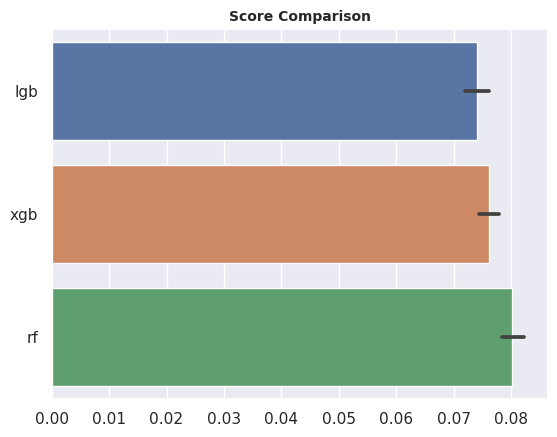

In [186]:
sns.barplot(data = score_list.reindex((score_list).mean().sort_values().index, axis = 1), orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 10);

In [191]:
weights = Ridge(positive = False, fit_intercept = False).fit(X = oof_list, y = y_train).coef_

pd.DataFrame(weights, index = oof_list.columns, columns = ["Weight per Model"])

,Weight per Model
rf,0.076823
lgb,0.762394
xgb,0.147932


In [195]:
voter = VotingRegressor(models, weights=weights)

_, _, prediction = cross_validation_score(5, voter, 'Voting Ensemble')

Voting Ensemble| Val Score: 0.07402 ± 0.00246 | Train Score: 0.06416 ± 0.00046 


In [196]:
prediction

array([ 0.00341161, -0.09422725, -0.04975405, ...,  0.03383539,
       -0.06343283,  0.00162328])

In [198]:
submission = pd.DataFrame(X_test.index, columns = ['id'])
submission['x_e_out [-]'] = prediction
submission.to_csv('submission.csv', index = False)